![](https://camo.githubusercontent.com/8c5f84801d2a1883ca72b58062c87a5a8a5014f189011d288b47a15056ae98b4/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f30322e77656270)

In [10]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

---

### 1. GPT backbone : `DummyGPTModel`

In [1]:
import torch
import torch.nn as nn

In [12]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [13]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

---

In [14]:
import tiktoken

In [15]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [17]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
logits, logits.shape

(tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
          [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
          [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
          [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],
 
         [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
          [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
          [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
          [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
        grad_fn=<UnsafeViewBackward0>),
 torch.Size([2, 4, 50257]))

---

### 2. Layer normalization

Goal is to obtain a mean of `0.0` and a variance of `1.0`.

In [19]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(
    nn.Linear(5, 6),
    nn.ReLU()
)
out = layer(batch_example)

out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [57]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("mean:\n", mean, "\nvariance:\n", var)

out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)

print("-"*100)
torch.set_printoptions(sci_mode=False)
print("Normalized layer outputs:\n", out_norm)
print("mean:\n", mean, "\nvariance:\n", var)

mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>) 
variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
----------------------------------------------------------------------------------------------------
Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>) 
variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [59]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        return self.scale * norm_x + self.shift

In [60]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)

mean, var

(tensor([[    -0.0000],
         [     0.0000]], grad_fn=<MeanBackward1>),
 tensor([[1.0000],
         [1.0000]], grad_fn=<VarBackward0>))

---

### 3. GELU activation layer

An approximation, cheaper to compute, found via curve fitting :
$$
GELU(x) \approx 0.5 * x * \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} * (x + 0.044715 * x^3) \right] \right)
$$

In [61]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2./torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))

In [63]:
import matplotlib.pyplot as plt

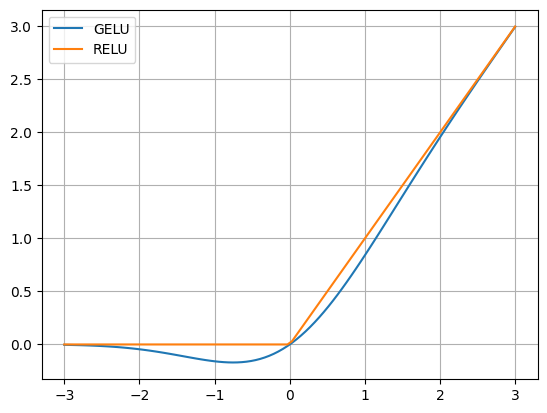

In [66]:
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.plot(x, y_gelu, label='GELU')
plt.plot(x, y_relu, label='RELU')
plt.legend()
plt.grid(True)

---

### 4. Feed forward network

In [67]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )

    def forward(self, x):
        return self.layers(x)

In [69]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
ffn(x).shape

torch.Size([2, 3, 768])

---

### 5. Shortcut (/skip/residual) connections

Problem to solve : *vanishing gradient problem*

In [70]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

**Without** shortcut connections

In [71]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


**With** shortcut connections

In [72]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


---

### 6. Transformer block

<div>
<img src="https://camo.githubusercontent.com/d4257fb18fb228ba2c2813a7b22300128346e0eb48b9ee884855ac9348c87fc6/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f31352e77656270" width="500"/>
</div>

In [103]:
from llms_from_scratch.ch03 import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            num_heads = cfg['n_heads'],
            dropout = cfg['drop_rate'],
            qkv_bias = cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [104]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

x.shape, output.shape

(torch.Size([2, 4, 768]), torch.Size([2, 4, 768]))

---

### 7. GPT architecture

<div>
<img src="https://camo.githubusercontent.com/6c8c392f72d5b9e86c94aeb9470beab435b888d24135926f1746eb88e0cc18fb/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f31332e776562703f31" width="500"/>
</div>

In [105]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)

        logits = self.out_head(x)
        return logits

In [92]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print(batch)
print(out.shape)
print(out)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [95]:
total_params = sum(p.numel() for p in model.parameters())

f'{total_params:,}'

'163,009,536'

In [97]:
model.tok_emb.weight.shape, model.out_head.weight.shape

(torch.Size([50257, 768]), torch.Size([50257, 768]))

In [98]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())

f'{total_params_gpt2:,}'

'124,412,160'

In [102]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / 1024**2

f'{total_size_mb:.2f} MB'

'621.83 MB'

---

### 7. Generating text

<div>
<img src="https://camo.githubusercontent.com/1e55260d5caca3ac6bd1215ca36973e0a0779995487ed9486f510e5baa108072/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830345f636f6d707265737365642f31372e77656270" width="800"/>
</div>